In [1]:
from IPython.display import display
from IPython.display import Image

# A Python tutorial on validating gVirtualXRay
## Analytic simulation vs. Monte Carlo simulation in the monochromatic case: 80 keV
### Computing the energy fluence
#### Authors: F. P. Vidal and J. M. Létang

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages. We use here a monochromatic source.

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is monochromatic, with an enegy of 80 keV.

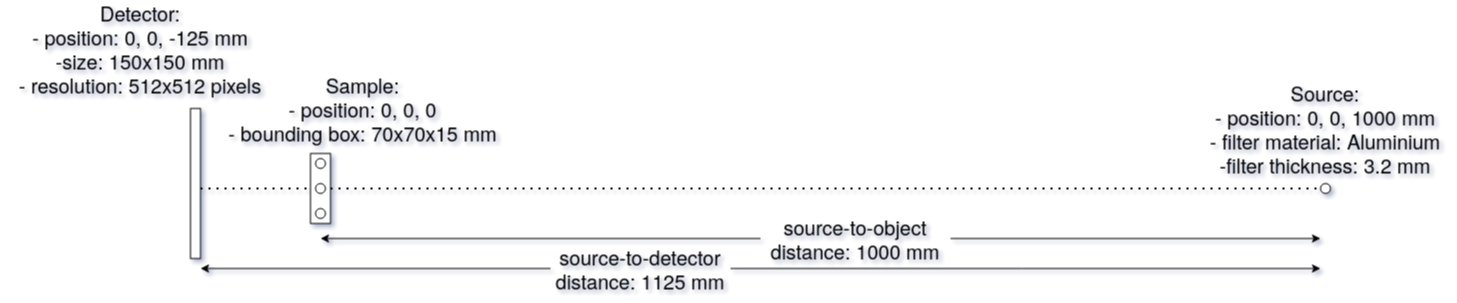

In [2]:
Image(filename="../doc/setup.png")

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

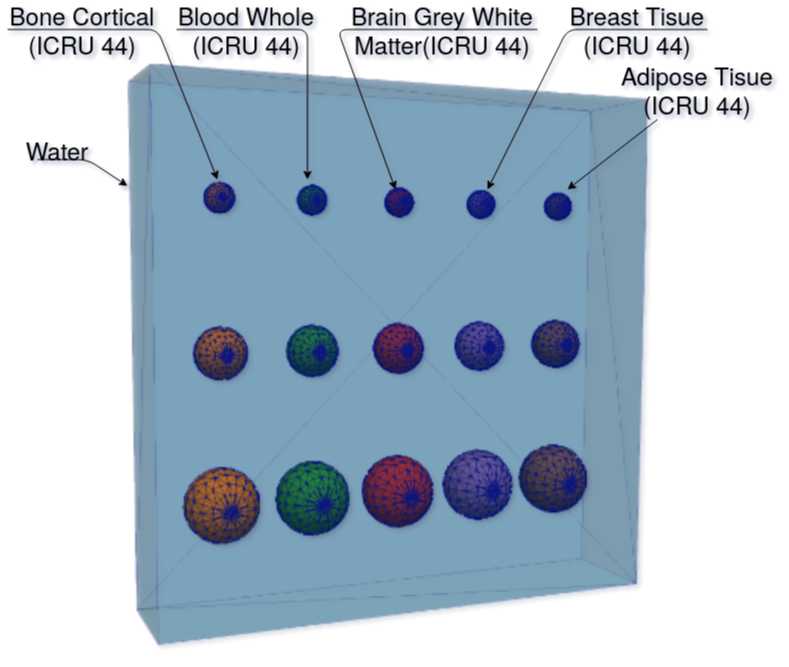

In [3]:
Image(filename="../doc/sample.png", width=400)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is MAPE 0.44%. The [zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 99.89%. 
The [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.88. 
As MAPE is low (close to 0), SSIM is 0.88, and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

## Import packages

In [4]:
%matplotlib inline

import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim

from tifffile import imread, imsave # Load/Write TIFF files

import datetime # For the runtime

import viewscad # Use OpenSCAD to create STL files

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook

SimpleGVXR 1.0.1 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux


## Reference image

We first load the reference image that has been simulated using [Gate](http://www.opengatecollaboration.org/) wrapper for CERN's [Geant4](https://geant4.web.cern.ch/). Here we ignore scattering.

In [5]:
Image = imread("Gate_data/monoE_flat.tif") # Already corrected
Full_field = np.ones(Image.shape) # Perfect full field image
Dark_field = np.zeros(Full_field.shape) # Perfect dark field image

Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
\begin{equation}
\mathbf{Proj} = \frac{\boldsymbol{I} - \boldsymbol{D}}{\boldsymbol{F} - \boldsymbol{D}}
\label{eq:flat-fields}
\end{equation}
where $\boldsymbol{F}$ (full fields) and $\boldsymbol{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. 
<!-- Note that with an ideal detector ($\boldsymbol{R}_i=E_i$), pixels of $\boldsymbol{D}$ are null, and pixels of $\boldsymbol{F}$ are equal to $\sum_i E_i \; \boldsymbol{N}_i$. 
 -->

We now apply the flat-field correction to `Image`.

In [6]:
gate_image = (Image - Dark_field) / (Full_field - Dark_field)
# gate_image = Image / np.mean(Full_field)

We plot the image using a linear look-up table and a power-law normalisation.

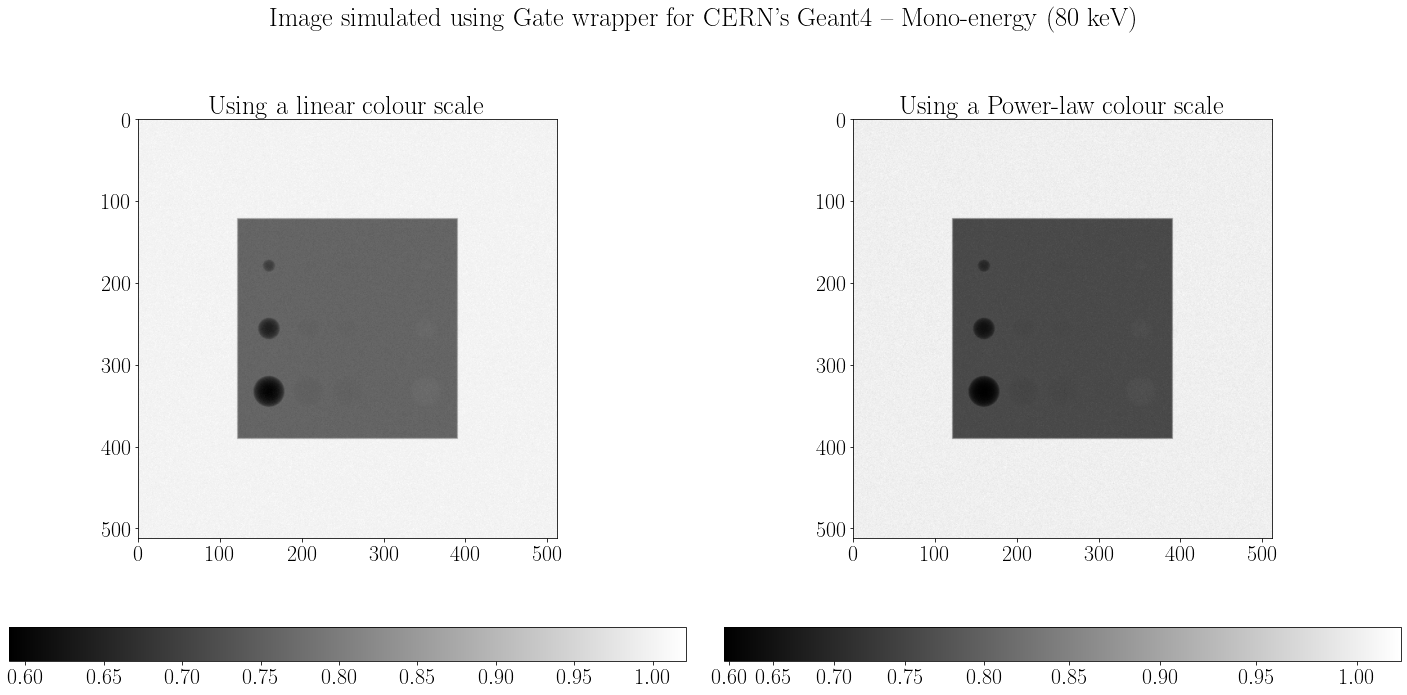

In [7]:
displayLinearPowerScales(gate_image,
                         "Image simulated using Gate wrapper for CERN's Geant4 -- Mono-energy (80 keV)",
                         "plots/reference_from_Gate-monoE-80keV")

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [8]:
json2gvxr.initGVXR("notebook-2.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [9]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
	Source shape: PointSource


## Spectrum

The spectrum is monochromatic, with an energy of 80 keV.

In [10]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=1)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

	 1.0 photon of 80 keV


Plot the spectrum

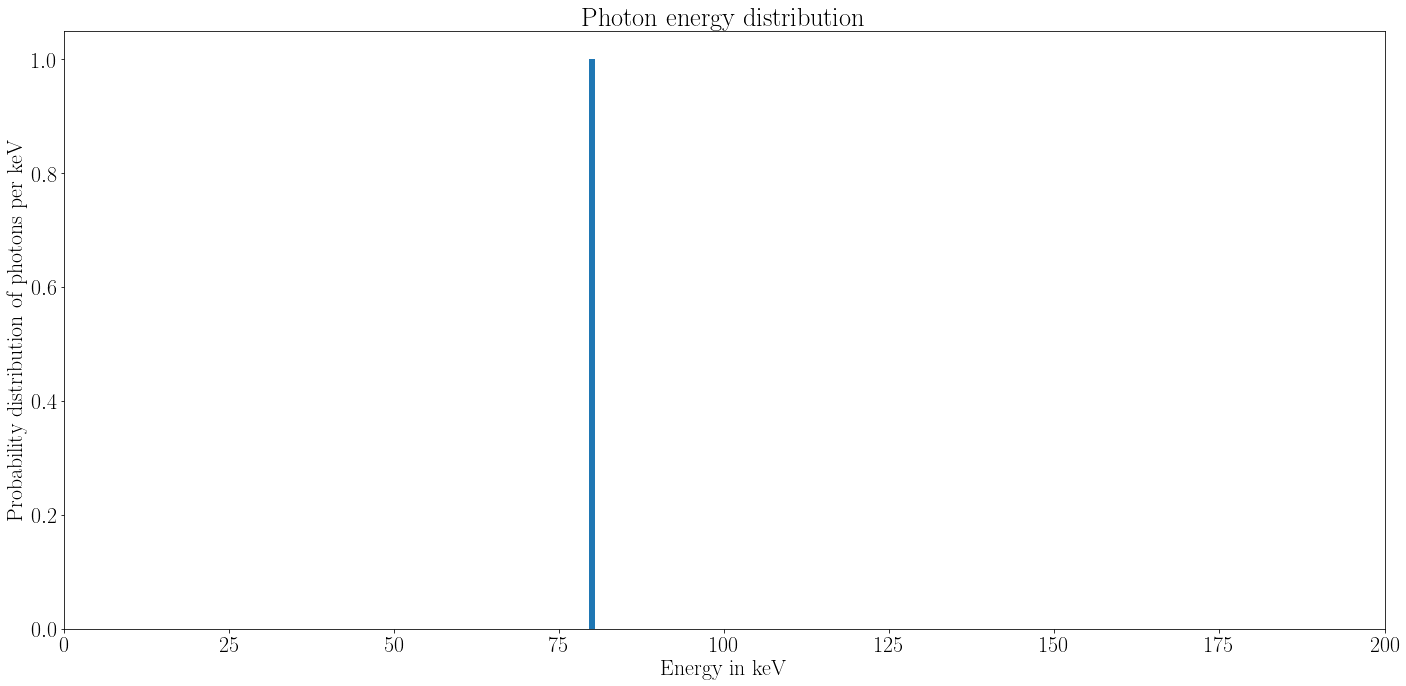

In [11]:
plotSpectrum(k, f, 'plots/spectrum-monoE-80keV')

## Detector

Create a digital detector

In [12]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [512, 512]
	Pixel spacing: [0.29296875, 0.29296875, 'mm']
INIT RENDER


## Sample

We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files.

In [13]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fn=25);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([offset, 0, 0])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [14]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([70, 70, 15])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [15]:
fname = 'CAD_models/matrix.stl'
if not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_matrix_str + openscad_make_spheres_str, outfile=fname)

In [16]:
openscad_cube_str = """

color("red")
    scale([70, 70, 15])
        cube(1, center = true);

"""

In [17]:
fname = 'CAD_models/cube.stl'
if not os.path.isfile(fname):
    
    r = viewscad.Renderer()
    r.render(openscad_cube_str, outfile='gvxr/input/cube.stl')

The spheres

In [18]:
openscad_col_str_set = []

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");")
    
    fname = 'CAD_models/col_' + str(i) + '.stl'
    if not os.path.isfile(fname):

        r = viewscad.Renderer()
        r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile=fname)

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [19]:
json2gvxr.initSamples(verbose=1)

Load the 3D data

	Load Bone_Cortical_ICRU_44 in CAD_models/col_0.stl using mm
file_name:	CAD_models/col_0.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-2.99606, -2.19961, -0.496354)	(-2, 2.49901, 0.496354)
	Load Blood_Whole_ICRU_44 in CAD_models/col_1.stl using mm
file_name:	CAD_models/col_1.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-1.74606, -2.19961, -0.496354)	(-0.75, 2.49901, 0.496354)
	Load Brain_Grey_White_Matter_ICRU_44 in CAD_models/col_2.stl using mm
file_name:	CAD_models/col_2.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-0.496057, -2.19961, -0.496354)	(0.5, 2.49901, 0.496354)
	Load Breast_Tissue_ICRU_44 in CAD_models/col_3.stl using mm
file_name:	CAD_models/col_3.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(0.753943, -2.19961, -0.496354)	(1.75, 2.49901, 0.496354)
	Load Adipose_Tissue_ICRU_44 in CAD_models/col_4.stl using mm
file_name:	CAD_models/col_4.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(2

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [20]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(719.6787109375)
gvxr.setSceneRotationMatrix([0.7624880075454712, 0.09040657430887222, -0.6406543850898743, 0.0,
                             0.05501500517129898, 0.9775413870811462, 0.20342488586902618, 0.0,
                             0.6446591019630432, -0.190354123711586, 0.7403913140296936, 0.0,
                             0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [21]:
screenshot = gvxr.takeScreenshot()

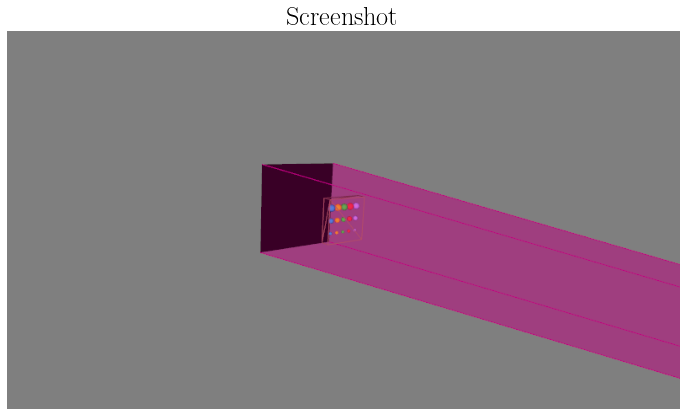

In [22]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-monoE-80keV.pdf')
plt.savefig('plots/screenshot-beam-off-monoE-80keV.png')

Compute an X-ray image 100 times (to gather performance statistics)

In [23]:
gvxr.enableArtefactFilteringOnCPU()
# gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix


runtimes = []

for i in range(100):
    start_time = datetime.datetime.now()
    gvxr.computeXRayImage()
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

Save an X-ray image

In [24]:
# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())
imsave('gVirtualXRay_output_data/projection_raw_integration_GPU_monoE-80keV.tif', x_ray_image_integration_GPU.astype(np.single))

Flat-field correction

In [25]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy_in_keV += energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [26]:
white = np.ones(x_ray_image_integration_GPU.shape) * total_energy_in_MeV
dark = np.zeros(x_ray_image_integration_GPU.shape)

x_ray_image_integration_GPU = (x_ray_image_integration_GPU - dark) / (white - dark)

Save the corresponding image

In [27]:
imsave('gVirtualXRay_output_data/projection_corrected_integration_GPU_monoE-80keV.tif', x_ray_image_integration_GPU.astype(np.single))

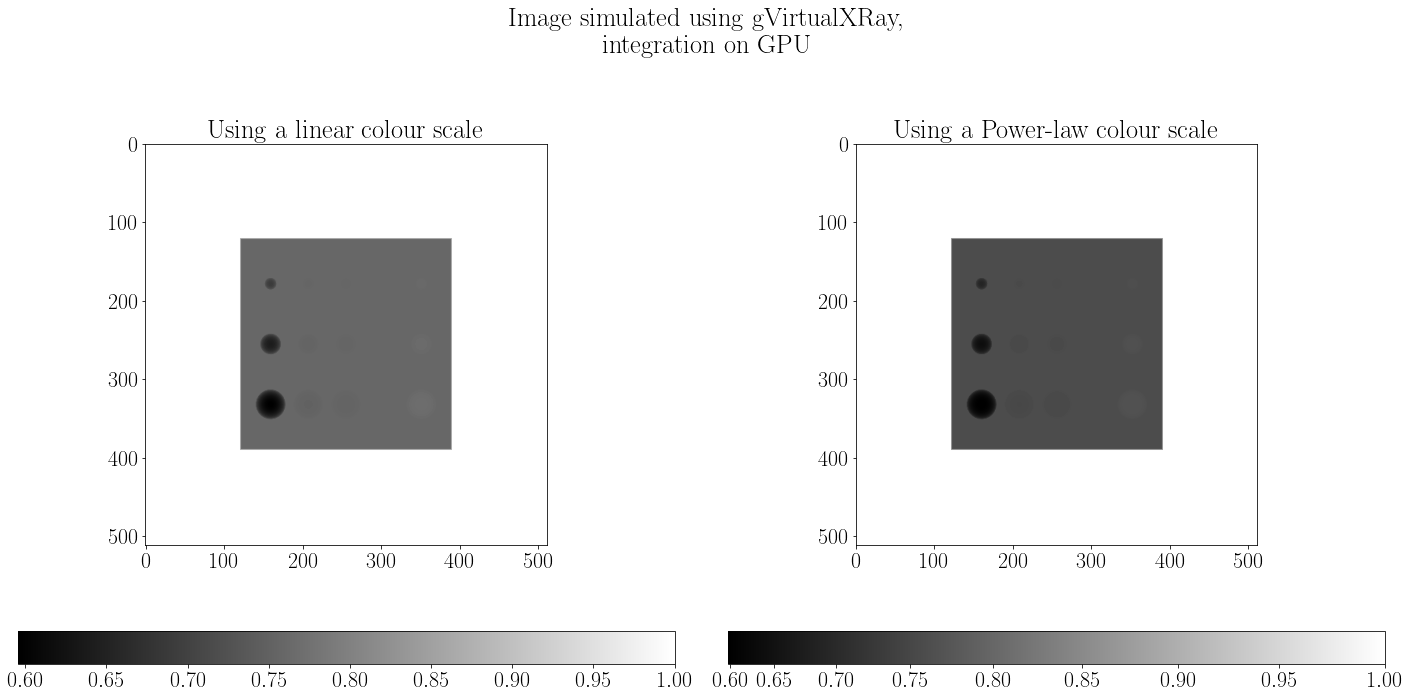

In [28]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay,\nintegration on GPU", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image_integration_GPU, cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_integration_GPU, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_integration_GPU-monoE-80keV.pdf')
plt.savefig('plots/x_ray_image_integration_GPU-monoE-80keV.png')

Compare the manual implementation with gvxr's

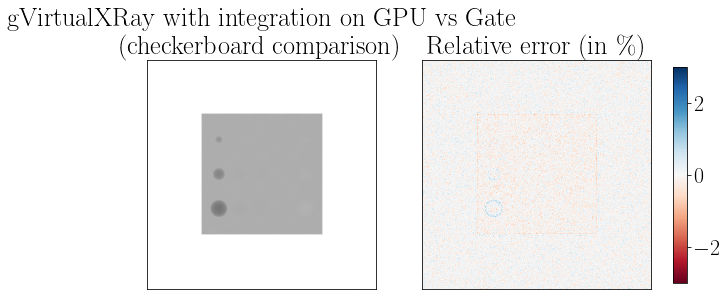

In [29]:
compareImages(x_ray_image_integration_GPU, gate_image,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-monoE-80keV')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [30]:
MAPE_integration_GPU = mape(gate_image, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(gate_image, x_ray_image_integration_GPU, data_range=gate_image.max() - gate_image.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

MAPE_integration_GPU: 0.44%
ZNCC_integration_GPU: 99.89%
SSIM_integration_GPU: 0.88


Get the total number of triangles

In [31]:
number_of_triangles = 0

for mesh in json2gvxr.params["Samples"]:
    label = mesh["Label"]
    number_of_triangles += gvxr.getNumberOfPrimitives(label)

In [32]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

Print a row of the table for the paper

In [33]:
print("Mono energy (80 keV), sphere inserts & Gate & " + 
      "{0:0.2f}".format(100 * MAPE_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "\\%    &    " +
      "{0:0.2f}".format(SSIM_integration_GPU) + "    &    $" +
      str(json2gvxr.params["Detector"]["NumberOfPixels"][0]) + " \\pm " + str(json2gvxr.params["Detector"]["NumberOfPixels"][1]) + "    &    " +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$ \\\\")

Mono energy (80 keV), sphere inserts & Gate & 0.44\%    &    99.89\%    &    0.88    &    $512 \pm 512    &    9702    &    $114 \pm 8$ \\


In both cases, MAPE is very small (less than 1%) and ZNCC is very high (more than 99%). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

In [34]:
font = {'size'   : 15
       }
matplotlib.rc('font', **font)

In [35]:

def fullCompareImages(gate_image: np.array, gvxr_image: np.array, title: str, fname: str, log: bool=False, vmin=0.01, vmax=1.2):

    absolute_error = np.abs(gate_image - gvxr_image)
    relative_error = 100 * (gate_image - gvxr_image) / gate_image
    comp_equalized = compare_images(gate_image, gvxr_image, method='checkerboard', n_tiles=(15,15))

    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))

    relative_error = 100 * (gate_image - gvxr_image) / gate_image
    comp_equalized = compare_images(gate_image, gvxr_image, method='checkerboard', n_tiles=(15,15))

    if not log:
        im1 = axes.flat[0].imshow(gate_image, cmap="gray", vmin=0.25, vmax=1)
    else:
        im1 = axes.flat[0].imshow(gate_image, cmap="gray", norm=LogNorm(vmin=vmin, vmax=vmax))
    axes.flat[0].set_title("Gate (ground truth)")
    axes.flat[0].set_xticks([])
    axes.flat[0].set_yticks([])

    if not log:
        im2 = axes.flat[1].imshow(gvxr_image, cmap="gray", vmin=0.25, vmax=1)
    else:
        im2 = axes.flat[1].imshow(gvxr_image, cmap="gray", norm=LogNorm(vmin=vmin, vmax=vmax))
    axes.flat[1].set_title("gVirtualXRay")
    axes.flat[1].set_xticks([])
    axes.flat[1].set_yticks([])

    if not log:
        im3 = axes.flat[2].imshow(comp_equalized, cmap="gray", vmin=0.25, vmax=1)
    else:
        im3 = axes.flat[2].imshow(comp_equalized, cmap="gray", norm=LogNorm(vmin=vmin, vmax=vmax))
    axes.flat[2].set_title("Checkerboard comparison between\nGate \& gVirtualXRay")
    axes.flat[2].set_xticks([])
    axes.flat[2].set_yticks([])

    if not log:
        im4 = axes.flat[3].imshow(relative_error, cmap="RdBu", vmin=-5, vmax=5)
    else:
        im4 = axes.flat[3].imshow(relative_error, cmap="RdBu", norm=LogNorm(vmin=-5, vmax=5))
    axes.flat[3].set_title("Relative error (in \%)")
    axes.flat[3].set_xticks([])
    axes.flat[3].set_yticks([])

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.2, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8
    cb_ax = fig.add_axes([0.83, 0.425, 0.02, 0.15])
    cbar = fig.colorbar(im4, cax=cb_ax)

    plt.savefig(fname + '.pdf')
    plt.savefig(fname + '.png')

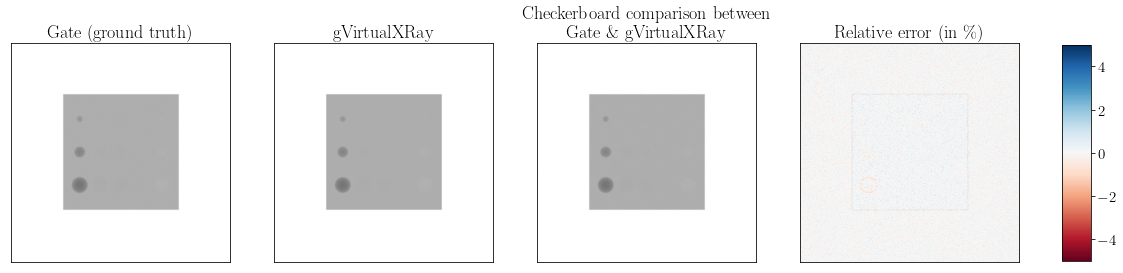

In [36]:
fullCompareImages(gate_image,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-monoE-80keV")

Plot the profiles

In [37]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

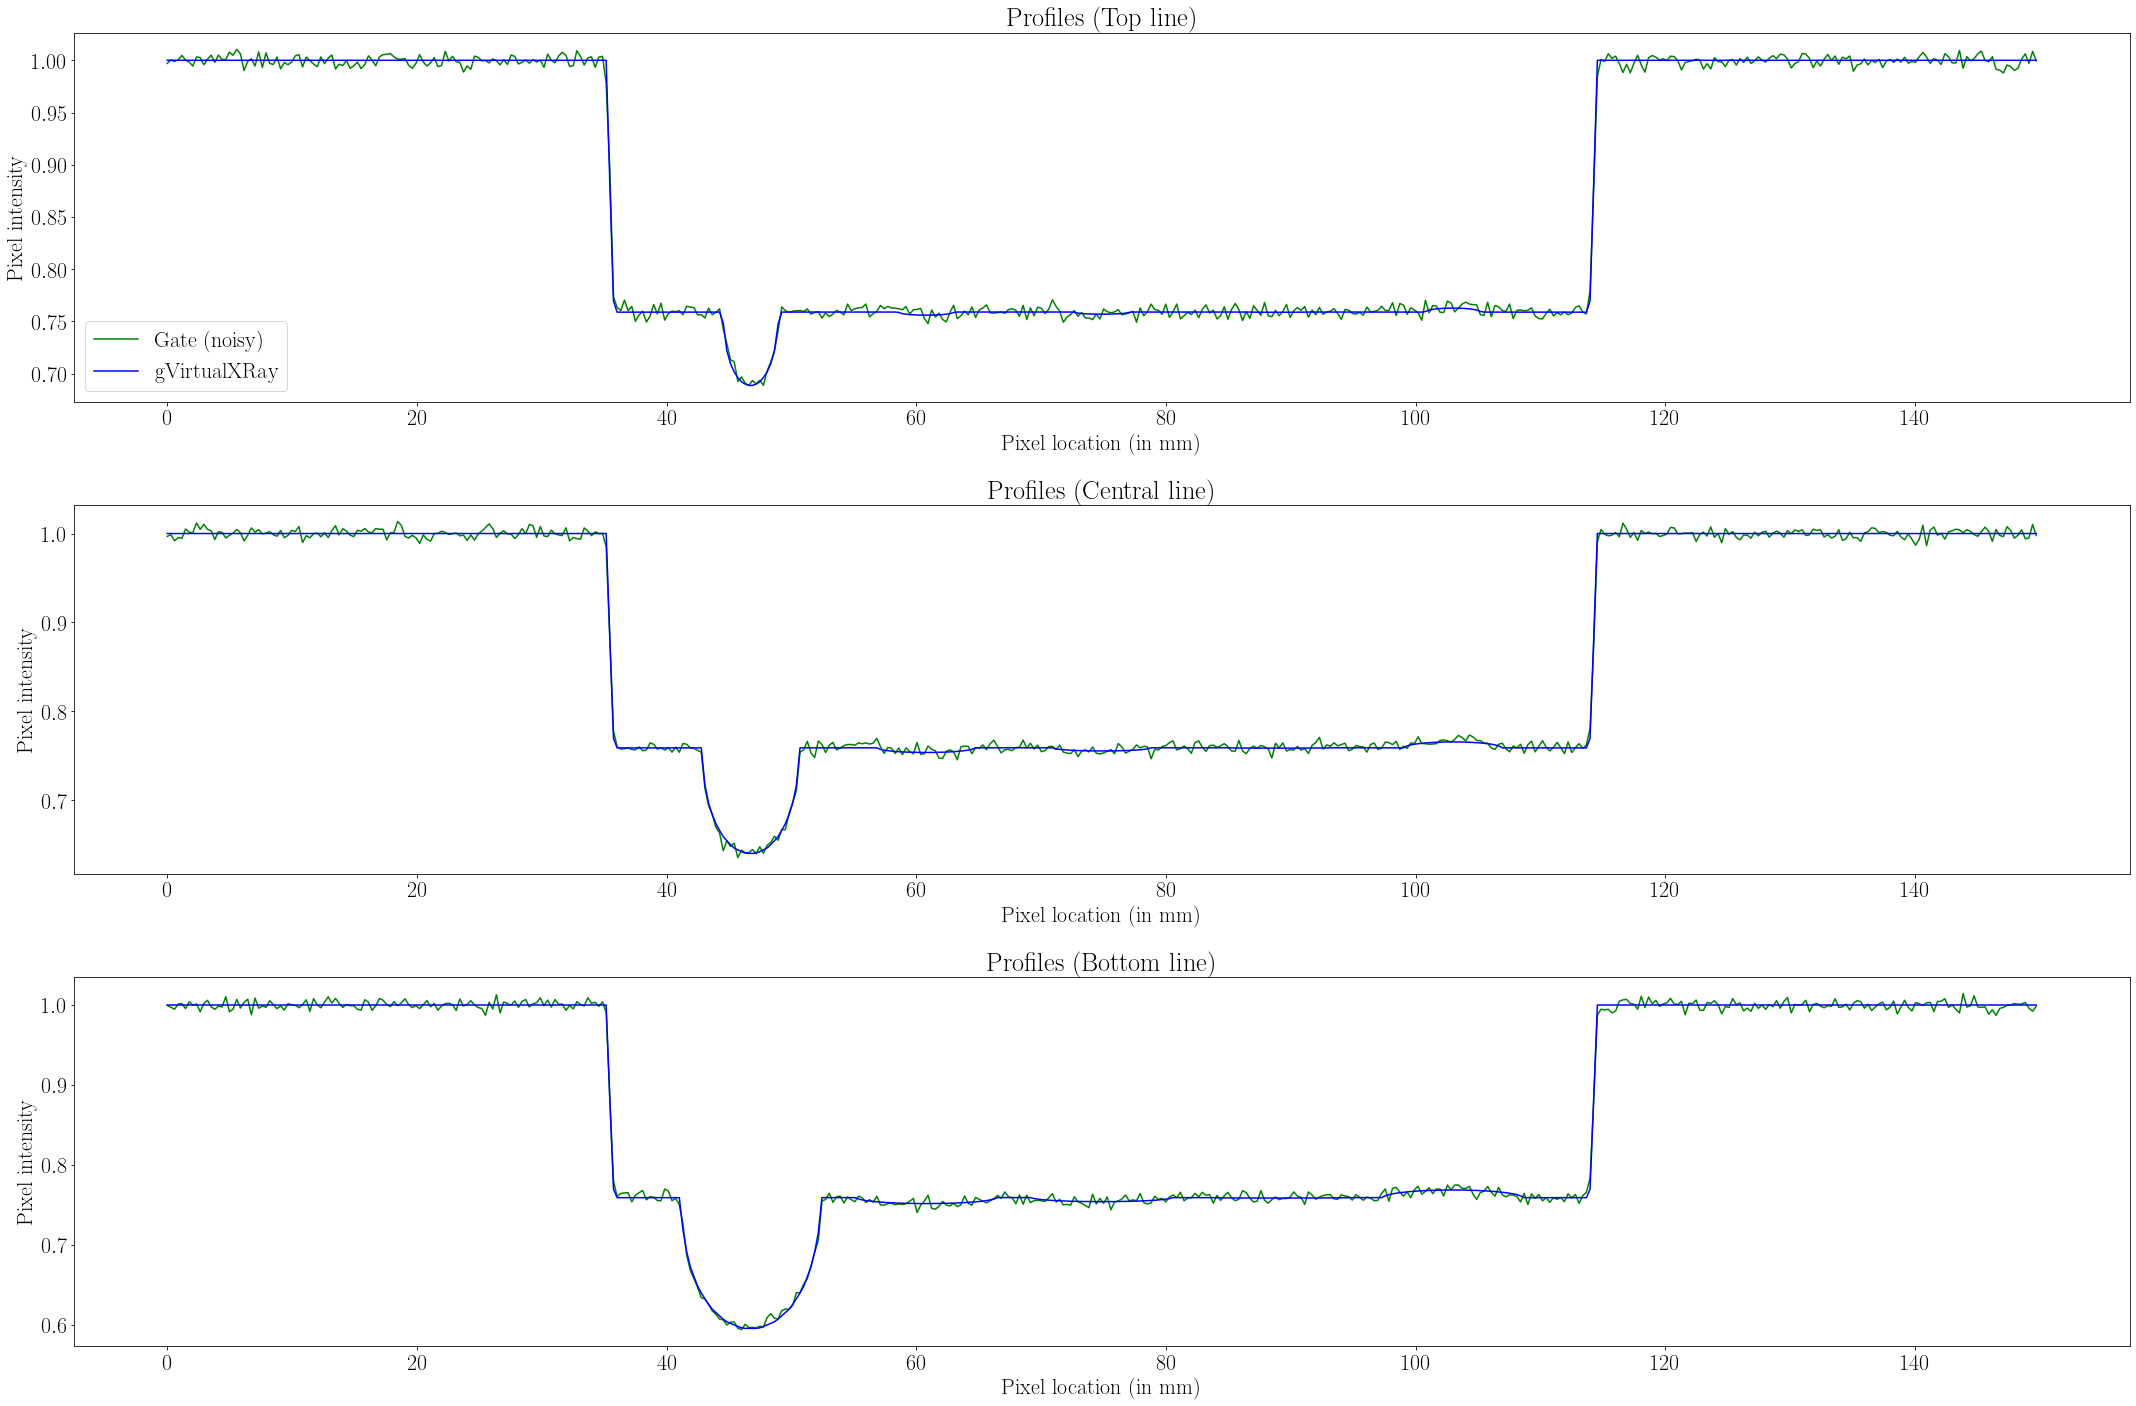

In [38]:
plotTwoProfiles(json2gvxr, gate_image, x_ray_image_integration_GPU, "plots/profiles-checkerboard-monoE-80keV")

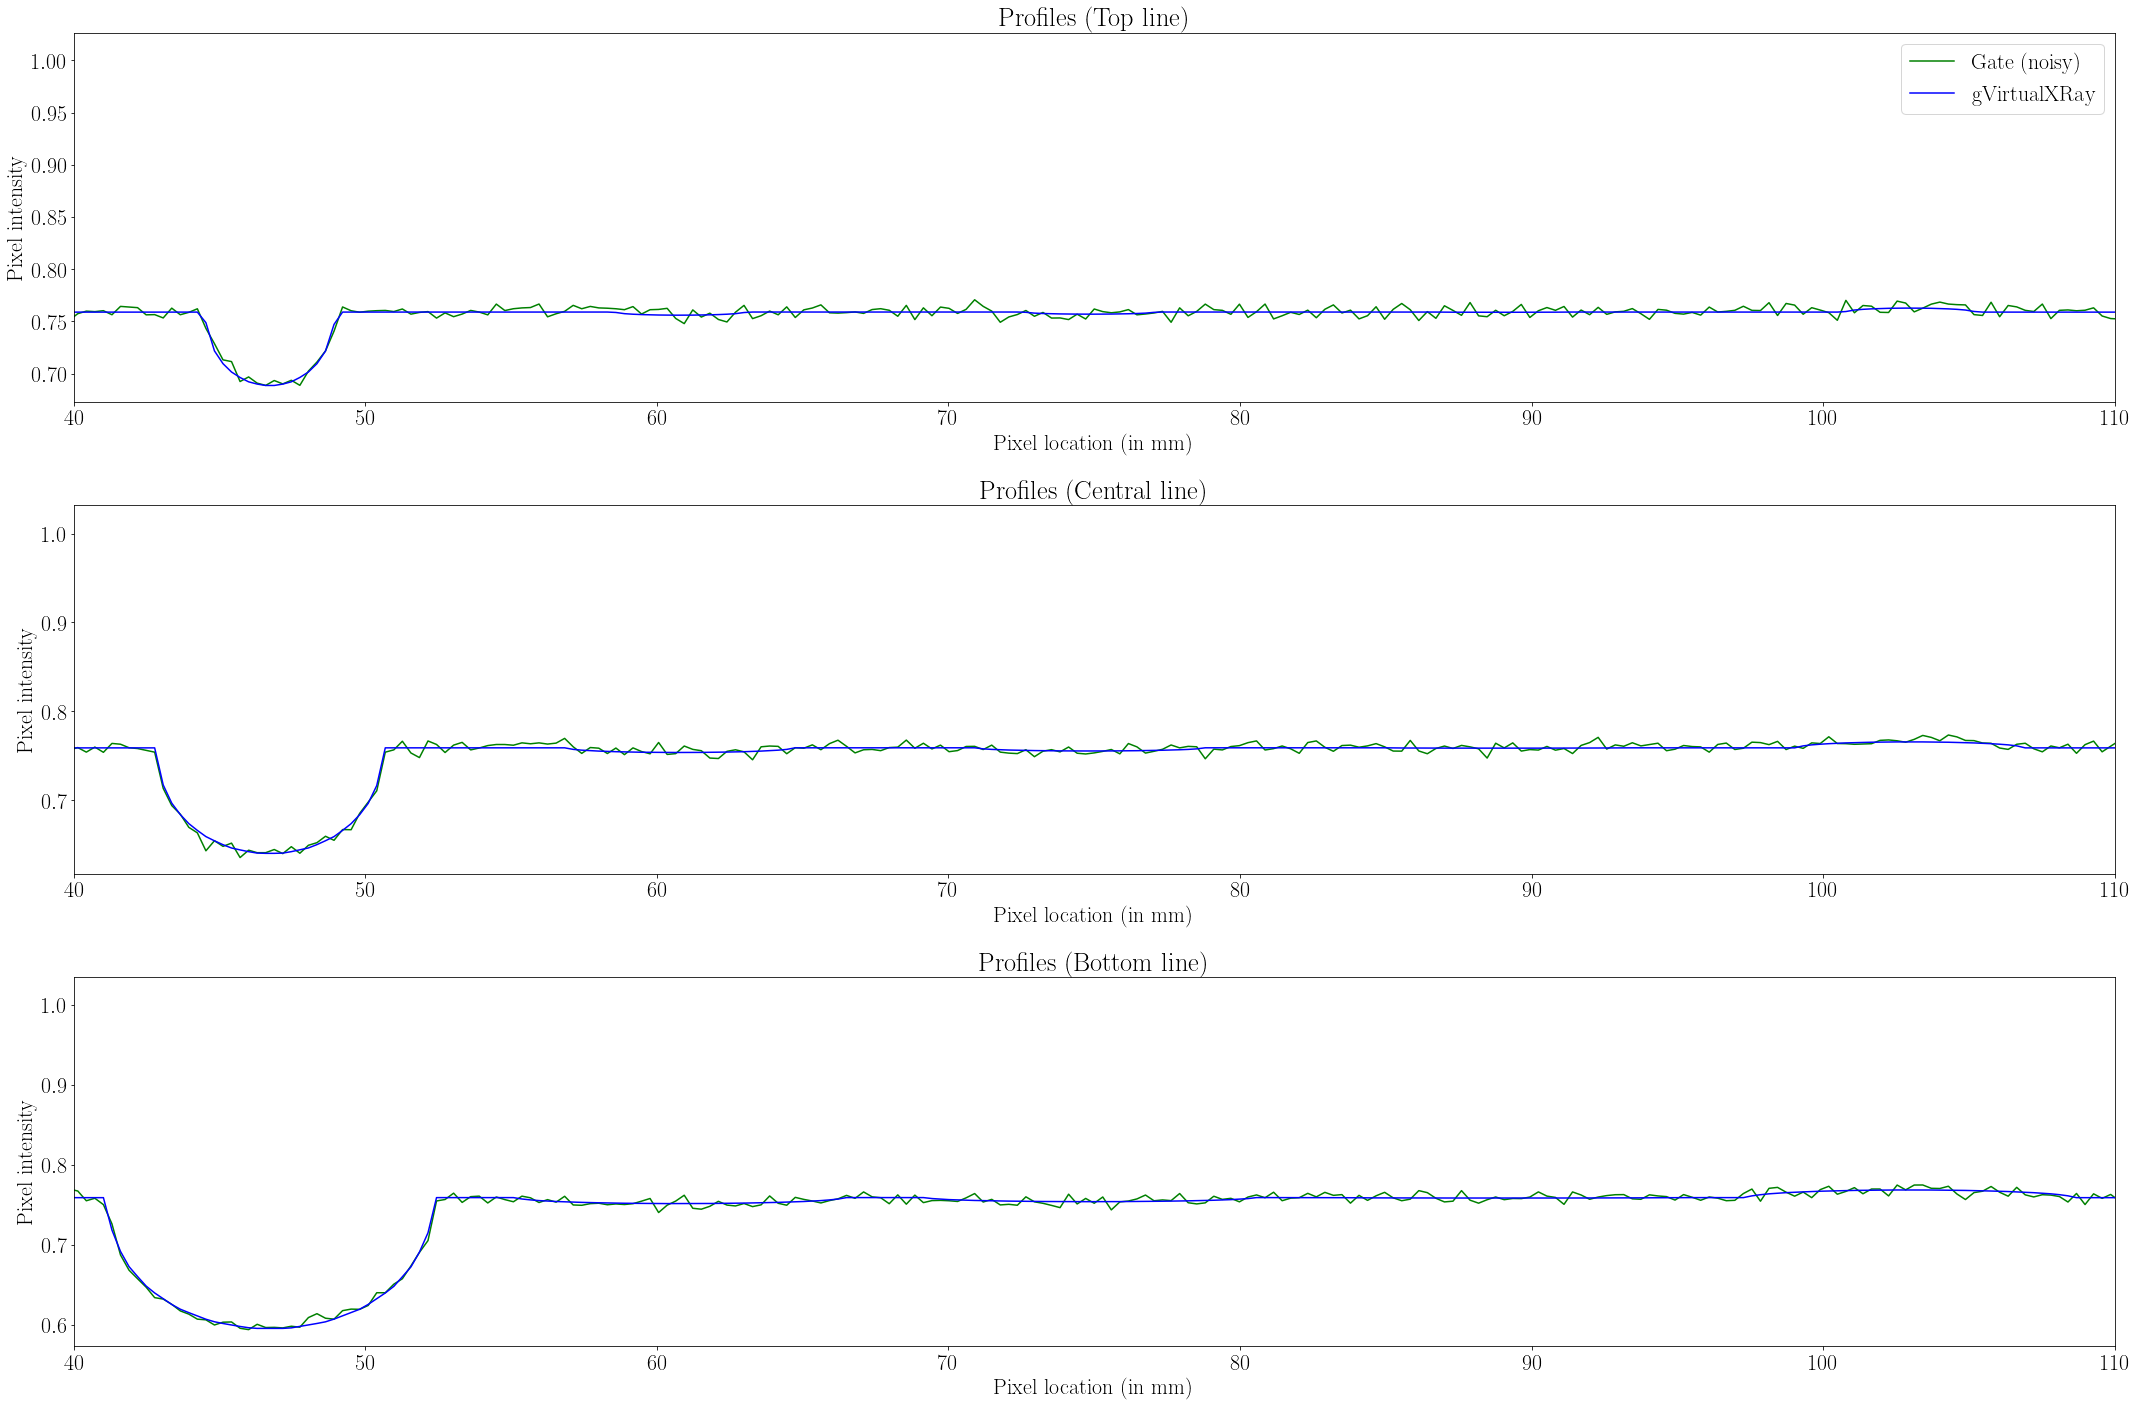

In [39]:
spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]
min_limit = round(40)
max_limit = round(512 * spacing - 40)
plotTwoProfiles(json2gvxr, gate_image, x_ray_image_integration_GPU, "plots/profiles-zoom-checkerboard-monoE-80keV", [min_limit, max_limit])

## All done

Destroy the window

In [40]:
gvxr.destroyAllWindows()

gvxrStatus:	Destroy all the windows
gvxrStatus:	Destroy window 0(0x5557b5a9aec0)
